/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sbittner/Documents/efn/results/June/tb/EFN_dirichlet_stochasticEta_D=3_K=100_M=1000_flow=20P_L=4_rs=1/results.npz'

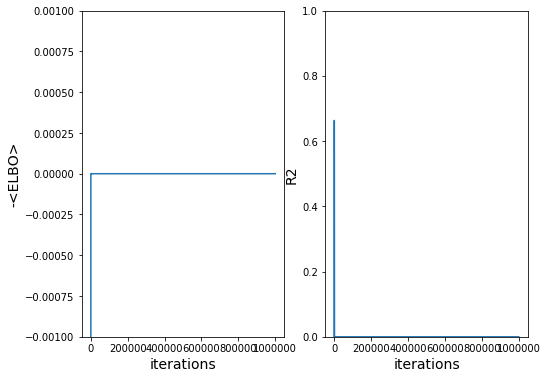

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from efn_util import get_flowdict, get_flowstring
import seaborn as sns

colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];
palette = sns.xkcd_palette(colors)

exp_fam = 'dirichlet';
give_hint = False;
D = 3;
K = 100;
M = 1000;
planar_flows = 20;
flow_dict = get_flowdict(0, 0, 0, planar_flows, 0, 0);
flowstring = get_flowstring(flow_dict);
if (exp_fam == 'dirichlet'):
    D_Z = D-1;
else:
    D_Z = D;
    
L = max(int(np.ceil(np.sqrt(D_Z))), 4);
give_inv_str = '';
    
datadir = '/Users/sbittner/Documents/efn/results/June/tb/';

fontsize = 14;
figsize = (8, 6);

for rs in range(3):
    fname = datadir + 'EFN_%s_stochasticEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/results.npz' \
                                          % (exp_fam, give_inv_str, D, K, M, flowstring, L, rs);
    npzfile = np.load(fname);

    test_elbos = npzfile['test_elbos'];
    test_R2s = npzfile['test_R2s'];
    check_rate = npzfile['check_rate'];

    nits = test_R2s.shape[0];
    iterations = np.arange(check_rate, nits*check_rate+1, check_rate);

    mean_test_elbos = np.mean(test_elbos, 1);
    mean_test_R2s = np.mean(test_R2s, 1);

    plt.figure(figsize=figsize);
    plt.subplot(1,2,1);
    plt.plot(iterations, -mean_test_elbos);
    plt.xlabel('iterations', fontsize=fontsize);
    plt.ylabel('-<ELBO>', fontsize=fontsize);
    plt.ylim([-mean_test_elbos[10], -np.min(mean_test_elbos)]);

    plt.subplot(1,2,2);
    plt.plot(iterations, mean_test_R2s);
    plt.xlabel('iterations', fontsize=fontsize);
    plt.ylabel('R2', fontsize=fontsize);
    plt.ylim([0, 1]);
plt.show();

In [95]:
def find_convergence(mean_test_elbos, mean_test_r2s, check_rate, wsize, delta_thresh):
    iterations = np.arange(wsize*check_rate, nits*check_rate+1, wsize*check_rate);
    N = iterations.shape[0];
    mean_test_elbo = np.zeros((N,));
    mean_test_R2 = np.zeros((N,));
    for i in range(N):
        mean_test_elbo[i] = np.mean(mean_test_elbos[(i*wsize):((i+1)*wsize)]);
        mean_test_R2[i] = np.mean(mean_test_R2s[(i*wsize):((i+1)*wsize)]);

    elbo_deltas = np.zeros((N-1,));
    r2_deltas = np.zeros((N-1,));
    for i in range(1,N):
        elbo_deltas[i-1] = (mean_test_elbo[i-1] - mean_test_elbo[i]) / mean_test_elbo[i-1];
        r2_deltas[i-1] = (mean_test_R2[i] - mean_test_R2[i-1]) / mean_test_R2[i-1];
    ind = np.argmax(np.logical_and(elbo_deltas < delta_thresh, r2_deltas < delta_thresh));
    return wsize*ind;

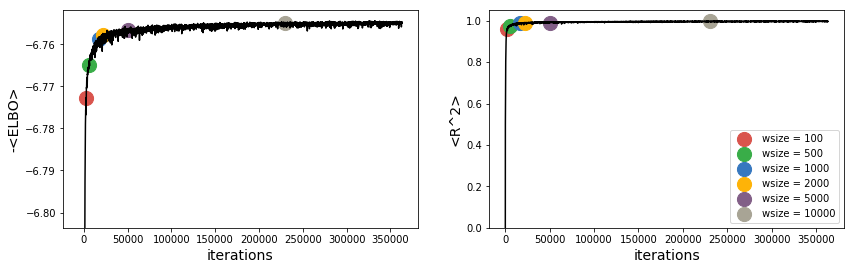

In [110]:
D = 3;
planar_flows = 5;
flow_dict = get_flowdict(0, 0, 0, planar_flows, 0, 0);
flowstring = get_flowstring(flow_dict);
rs = 0;
M = 1000;
fname = datadir + 'EFN_%s_stochasticEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/results.npz' \
                                      % (exp_fam, give_inv_str, D, K, M, flowstring, L, rs);
npzfile = np.load(fname);

test_elbos = npzfile['test_elbos'];
test_R2s = npzfile['test_R2s'];
check_rate = npzfile['check_rate'];

mean_test_elbos = np.mean(test_elbos, 1);
mean_test_R2s = np.mean(test_R2s, 1);
nits = np.argmax(mean_test_elbos==0);
mean_test_elbos = mean_test_elbos[:nits];
mean_test_R2s = mean_test_R2s[:nits];

delta_thresh = 1e-10;
wsizes = [1, 5, 10, 20, 50, 100];
num_wsizes = len(wsizes);
conv_it_inds = [];
legendstrs = [];
for i in range(num_wsizes):
    wsize = wsizes[i];
    legendstrs.append('wsize = %d' % (wsize*check_rate));
    conv_it_inds.append(find_convergence(mean_test_elbos, mean_test_R2s, check_rate, wsize, delta_thresh));

iterations = np.arange(check_rate, check_rate*nits+1, check_rate);
plt.figure(figsize=(14,4));
size = 200*np.ones((1,));
plt.subplot(1,2,2);
for i in range(num_wsizes):
    plt.scatter(iterations[conv_it_inds[i]], mean_test_R2s[conv_it_inds[i]], s=size, c=palette[i]);
plt.legend(legendstrs);

    
plt.subplot(1,2,1);
plt.plot(iterations, -mean_test_elbos, 'k');
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('-<ELBO>', fontsize=fontsize);
ymin = -mean_test_elbos[10];
ymax = -np.min(mean_test_elbos);
ybuf = 0.05*(ymax-ymin);
plt.ylim([-mean_test_elbos[10], -np.min(mean_test_elbos) + ybuf]);

for i in range(num_wsizes):
    plt.scatter(iterations[conv_it_inds[i]], -mean_test_elbos[conv_it_inds[i]], s=size, c=palette[i]);
    
plt.subplot(1,2,2);
plt.plot(iterations, mean_test_R2s, 'k');
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('<R^2>', fontsize=fontsize);
plt.ylim([0, 1.05]);
plt.show();


In [ ]:
print(conv_its);
print(mean_test_elbos.shape);